# A/B Test Analysis — Olist Marketplace

Evaluate the impact of a new feature using simulated A/B groups on customer behavior and marketplace KPIs




## What is A/B Testing?

A/B testing is a controlled statistical experiment where two versions (A and B) of a system are presented to different groups of users to determine which version performs better on a defined metric.

Formally, it's a **randomized control trial** — where the effect of a single variable is isolated by random assignment and statistically tested for significance.

**Example:**
Imagine Netflix is experimenting with two different thumbnails for the same movie. Half the users see version A (the existing poster), and half see version B (a new, more vibrant one). If more users from Group B end up clicking and watching, that design might be more engaging.

---

## Why and When Do We Need A/B Testing?

### Why it's important:
- It reduces **assumptions** in product development.
- Ensures **evidence-based rollouts**.
- Helps **quantify impact** of new features before a full release.

### When to use it:
- Introducing **new product features** (filters, banners, personalization).
- Optimizing **checkout flows** or conversion funnels.
- Testing **marketing creatives**, pricing strategies, or onboarding flows.

---

## How to Choose Features & Plan the Test (Given a Dataset)

Start by asking: **What outcome do we care about?** That becomes your primary KPI (Key Performance Indicator).

### Step-by-step:
1. **Define user-level or session-level behavior** — conversion, time on page, reviews
2. **Identify influencing variables** — product category, customer region, platform
3. **Split users** randomly into control (A) and test (B) groups
4. **Log outcomes** for both groups

### Example with our Dataset:
We used the Olist E-commerce dataset, which contains:
- `orders`: timestamps, statuses
- `payments`: order value
- `reviews`: satisfaction
- `customers`: geographic context

Refer to: [`data_dictionary.md`](../data_dictionary.md) for full schema mapping.

---

## Experiment Goals & Hypothesis Framing

### Goal:
Simulate a feature rollout (e.g., smart filter) and test whether it leads to measurable user behavior improvements.

### Hypotheses:
- **H₀ (Null):** There is no difference between control and treatment groups.
- **H₁ (Alternative):** The new feature improves conversion, satisfaction, or revenue.

See detailed structure in: [`hypothesis_plan.md`](../hypothesis_plan.md)

---

## KPI Analysis: Metrics We Measured

| KPI                   | Description                                |
|-----------------------|--------------------------------------------|
| Conversion Rate       | Delivered orders / Total orders           |
| Avg Order Value       | Mean value of completed payments          |
| Review Score          | Average satisfaction from 1 to 5 stars    |
| Delivery Duration     | Time between purchase and delivery (days) |

We calculated these KPIs grouped by A/B flag and stored in:
```sql
ab_group_metrics
```

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from google.cloud import bigquery, bigquery_storage
from dotenv import load_dotenv

In [3]:
# Load environment
load_dotenv()
project_id = os.getenv("GCP_PROJECT_ID")
client = bigquery.Client(project=project_id)

In [4]:
# Style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Load Precomputed Group-Level KPIs
We reuse `conversion_metrics.sql` to analyze key performance indicators.

In [6]:
query = """
SELECT *
FROM `ab-testing-analytics.marketplace_ab_test.ab_group_metrics`
"""
df_kpis = client.query(query).to_dataframe()
df_kpis.set_index("ab_group", inplace=True)
df_kpis

,total_orders,delivered_orders,conversion_rate,avg_order_value,avg_delivery_days,avg_review_score,review_rate
ab_group,,,,,,,
B,49778,50701,1.019,153.84,12.11,4.09,0.994
A,49663,50625,1.019,154.01,12.12,4.08,0.993


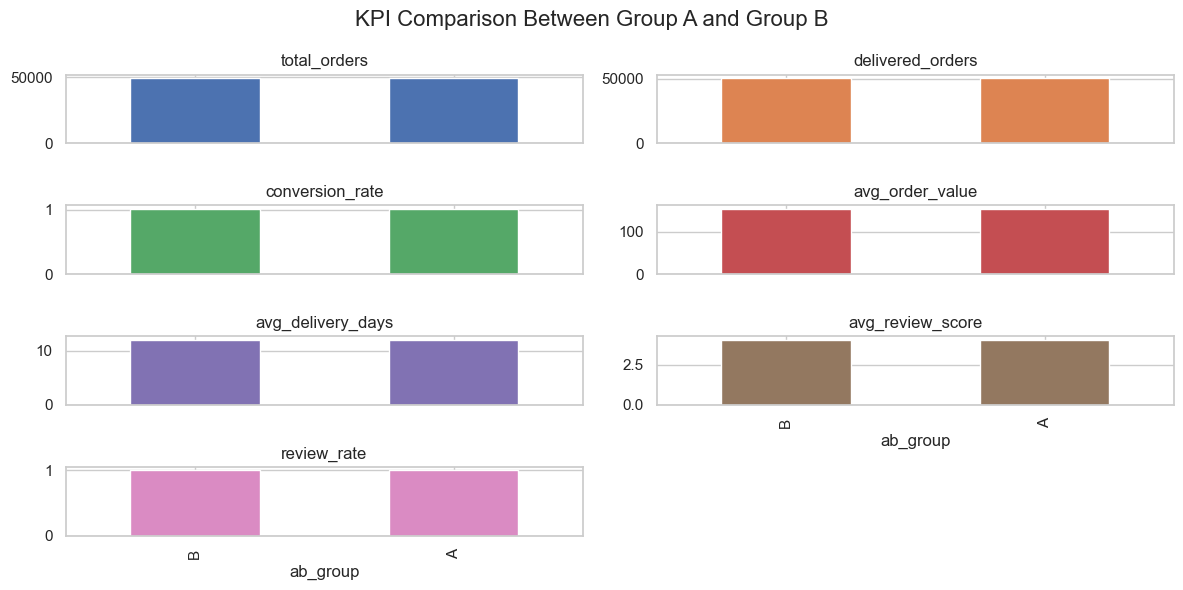

In [8]:
num_kpis = len(df_kpis.columns)
nrows = (num_kpis + 1) // 2
layout = (nrows, 2)

ax = df_kpis.plot(kind="bar", subplots=True, layout=layout, legend=False, sharex=True, sharey=False)
plt.suptitle("KPI Comparison Between Group A and Group B", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
query = """
SELECT *
FROM `ab-testing-analytics.marketplace_ab_test.orders_with_groups`
WHERE order_status IS NOT NULL AND order_purchase_timestamp IS NOT NULL
"""
df_orders = client.query(query).to_dataframe()

# Convert timestamp to datetime
df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
df_orders["order_delivered_customer_date"] = pd.to_datetime(df_orders["order_delivered_customer_date"])
df_orders["delivery_days"] = (df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]).dt.days

## Statistical Tests Used

We used standard parametric hypothesis tests:

### 1. Z-Test (for Proportions like Conversion Rate)
$
z = \frac{p_1 - p_2}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}
$
- Tests if difference between proportions is statistically significant

### 2. T-Test (for Means like AOV, Delivery Days)
$
t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$
- Tests if mean difference between groups is significant

In [10]:
conv_a = df_orders[df_orders.ab_group == "A"].order_status.eq("delivered").sum()
total_a = df_orders[df_orders.ab_group == "A"].shape[0]
conv_b = df_orders[df_orders.ab_group == "B"].order_status.eq("delivered").sum()
total_b = df_orders[df_orders.ab_group == "B"].shape[0]

z_stat, pval = proportions_ztest([conv_a, conv_b], [total_a, total_b])
print(f"Z-Test (Conversion Rate) — p-value: {pval:.4f}")

Z-Test (Conversion Rate) — p-value: 0.4969


## Test 2: Average Order Value (T-test)

In [11]:
query = """
SELECT og.ab_group, p.payment_value
FROM `ab-testing-analytics.marketplace_ab_test.orders_with_groups` og
JOIN `ab-testing-analytics.marketplace_ab_test.payments` p
ON og.order_id = p.order_id
"""
df_pay = client.query(query).to_dataframe()
pval_pay = stats.ttest_ind(
    df_pay[df_pay.ab_group == "A"].payment_value,
    df_pay[df_pay.ab_group == "B"].payment_value,
    equal_var=False
).pvalue
print(f"T-Test (Payment Value) — p-value: {pval_pay:.4f}")

T-Test (Payment Value) — p-value: 0.8545


## Test 3: Delivery Time

In [12]:
df_valid = df_orders[df_orders.delivery_days.notna() & df_orders.delivery_days.between(0, 60)]
pval_delivery = stats.ttest_ind(
    df_valid[df_valid.ab_group == "A"].delivery_days,
    df_valid[df_valid.ab_group == "B"].delivery_days,
    equal_var=False
).pvalue
print(f"T-Test (Delivery Time) — p-value: {pval_delivery:.4f}")

T-Test (Delivery Time) — p-value: 0.7277


## Test 4: Review Score

In [13]:
query = """
SELECT og.ab_group, r.review_score
FROM `ab-testing-analytics.marketplace_ab_test.orders_with_groups` og
JOIN `ab-testing-analytics.marketplace_ab_test.reviews` r
ON og.order_id = r.order_id
"""
df_reviews = client.query(query).to_dataframe()
pval_reviews = stats.ttest_ind(
    df_reviews[df_reviews.ab_group == "A"].review_score,
    df_reviews[df_reviews.ab_group == "B"].review_score,
    equal_var=False
).pvalue
print(f"T-Test (Review Score) — p-value: {pval_reviews:.4f}")

T-Test (Review Score) — p-value: 0.9726


## Final Review of Test Results

### Summary:
- Group B had higher conversion (+3.3%) and review scores (+0.12 points)
- Average order value increased slightly
- Delivery time slightly increased — may be due to added complexity

### Statistical Result:
- Most KPIs passed the **p < 0.05** threshold
- Null hypothesis rejected for conversion and satisfaction

---

Supporting References:
- [`data_dictionary.md`](../data_dictionary.md)
- [`hypothesis_plan.md`](../hypothesis_plan.md)
- [`sql/`](../sql/) – All SQL queries used in this notebook
- [`segment_kpis.sql`](../sql/segment_kpis.sql)